<a href="https://colab.research.google.com/github/m3-learning/FOLO_RHEED/blob/main/FOLOCropLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
K = tf.keras.backend
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import Callback

Generated dataset shapes:
X_train shape: (1, 48, 128, 1)
y_train shape: (1, 5, 5)


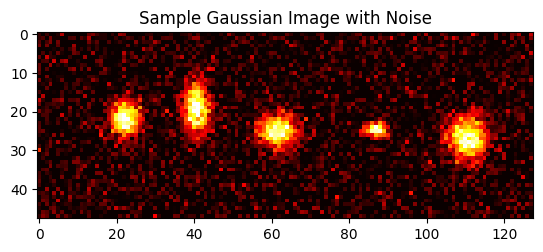

Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):
[[ 2.2230192e+01  2.1823881e+01  2.7670445e+00  3.2108405e+00
   1.2282296e-02]
 [ 4.0727715e+01  1.9173717e+01  2.3882382e+00  4.9080868e+00
  -6.9200337e-02]
 [ 6.1509647e+01  2.5047152e+01  3.4848371e+00  3.1003649e+00
   1.4933601e-01]
 [ 8.7150887e+01  2.4824081e+01  2.0508380e+00  1.4105102e+00
  -2.2079020e-03]
 [ 1.1056999e+02  2.6854912e+01  3.6080949e+00  4.0353732e+00
  -2.0931782e-02]]


In [5]:
def generate_gaussian_blob(image_size, mean, cov, angle, noise_std=0.01):
    """
    Generate a single Gaussian blob on an image with added random noise.
    """
    x, y = np.meshgrid(np.linspace(0, image_size[0] - 1, image_size[0]),
                       np.linspace(0, image_size[1] - 1, image_size[1]))
    x -= mean[0]
    y -= mean[1]

    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)

    x_rot = cos_angle * x + sin_angle * y
    y_rot = -sin_angle * x + cos_angle * y

    exponent = (x_rot ** 2) / (2 * cov[0] ** 2) + (y_rot ** 2) / (2 * cov[1] ** 2)
    blob = np.exp(-exponent)

    # Add random noise centered around the Gaussian blob
    noise = np.random.normal(0, noise_std, blob.shape)
    blob += noise

    return blob

def convert_parameters(parameters):
    """
    Convert Gaussian parameters from (amplitude, x0, y0, sigma_x, sigma_y) to (mean_x, mean_y, cov_x, cov_y, theta).
    """
    A, x0, y0, sigma_x, sigma_y = parameters

    mean_x = x0
    mean_y = y0
    cov_x = sigma_x
    cov_y = sigma_y

    # Calculate theta from the covariance values
    if cov_x != 0 and cov_y != 0:
        theta = 0.5 * np.arctan2(2 * cov_x * cov_y, (cov_x**2 - cov_y**2))
    else:
        theta = 0.0

    return mean_x, mean_y, cov_x, cov_y, theta

def create_training_data(num_samples, image_size=(128, 48), num_blobs=5, noise_std=0.05):
    """
    Create training data with Gaussian blobs and noise for the YOLO-style model.
    """
    X = np.zeros((num_samples, image_size[1], image_size[0], 1), dtype=np.float32)
    y = np.zeros((num_samples, num_blobs, 5), dtype=np.float32)

    for i in range(num_samples):
        image = np.zeros((image_size[1], image_size[0]), dtype=np.float32)
        blob_params = []

        # Generate y-values within 20% of each other
        base_y = np.random.uniform(0.4 * image_size[1], 0.6 * image_size[1])
        y_values = np.random.uniform(base_y * 0.8, base_y * 1.2, num_blobs)

        # Generate evenly spaced x-values with slight variation
        x_values = np.linspace(0, image_size[0], num_blobs + 2)[1:-1]
        x_values += np.random.uniform(-5, 5, num_blobs)

        for j in range(num_blobs):
            mean_x = x_values[j]
            mean_y = y_values[j]
            cov_x = np.random.uniform(2, 6)
            cov_y = np.random.uniform(1, 5)
            theta = np.random.uniform(-10, 10) * np.pi / 180  # Cap rotation at 10 degrees

            blob = generate_gaussian_blob((image_size[0], image_size[1]), (mean_x, mean_y), (cov_x, cov_y), theta, noise_std)
            image += blob

            # Store parameters for the label
            blob_params.append((mean_x, mean_y, cov_x, cov_y, theta))

        # Convert parameters to labels
        for j in range(num_blobs):
            mean_x, mean_y, cov_x, cov_y, theta = blob_params[j]
            y[i, j, :] = [mean_x, mean_y, cov_x, cov_y, theta]

        X[i, :, :, 0] = np.clip(image, 0, 1)

    return X, y

num_samples = 1  # Number of training samples
X_train, y_train = create_training_data(num_samples, noise_std=0.05)

print("Generated dataset shapes:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
plt.imshow(X_train[0].squeeze(), cmap='hot')
plt.title("Sample Gaussian Image with Noise")
plt.show()
print("Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):")
print(y_train[0])

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class CropLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(CropLayer, self).__init__(**kwargs)

    def call(self, inputs):
        image, crop_boxes = inputs
        batch_size = tf.shape(image)[0]
        num_boxes = tf.shape(crop_boxes)[1]
        crop_boxes = tf.reshape(crop_boxes, (batch_size * num_boxes, 4))  # Flatten the crop_boxes tensor
        box_indices = tf.range(batch_size)
        box_indices = tf.repeat(box_indices, repeats=num_boxes)

        cropped_images = tf.image.crop_and_resize(
            image, crop_boxes, box_indices, (48, 48)
        )

        # Reshape to (batch_size, num_boxes, 48, 48, channels)
        cropped_images = tf.reshape(cropped_images, (batch_size, num_boxes, 48, 48, tf.shape(image)[-1]))

        return cropped_images

def build_cnn_with_gaussian_prediction(input_shape):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Initial convolutions to process the full image
    x = layers.Conv2D(8, kernel_size=3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Predict 5 crop areas
    crop_pred = layers.Conv2D(16, kernel_size=3, activation='relu', padding='same')(x)
    crop_pred = layers.Flatten()(crop_pred)
    crop_pred = layers.Dense(64, activation='relu')(crop_pred)
    crop_pred = layers.Dense(5 * 4, activation='sigmoid', name='crop_prediction')(crop_pred)

    # Reshape crop predictions to [batch_size, 5, 4] format
    crop_boxes = layers.Reshape((5, 4))(crop_pred)

    # Crop the original input image
    cropped_images = CropLayer()([inputs, crop_boxes])

    x = layers.Conv2D(6, kernel_size=3, strides=1, padding='valid', data_format='channels_first')(cropped_images)
    x = layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=4, strides=4, data_format='channels_first')(x)

    x = layers.Conv2D(16, kernel_size=3, strides=1, padding='valid', data_format='channels_first')(x)
    x = layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2, data_format='channels_first')(x)

    x = layers.Flatten()(x)
    x = layers.Dense(98, activation='relu')(x)
    x = layers.Dense(52, activation='relu')(x)
    outputs = layers.Dense(5)(x)

    model = Model(inputs=inputs, outputs=[outputs, crop_pred])
    return model

# Example usage
input_shape = (48, 128, 1)
model = build_cnn_with_gaussian_prediction(input_shape)
model.summary()

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_3. Consider increasing the input size. Received input shape [None, 5, 48, 48, 1] which would produce output shape with a zero or negative value in a dimension.

X_train shape: (8000, 48, 128, 1)
y_train shape: (8000, 5, 5)
X_val shape: (2000, 48, 128, 1)
y_val shape: (2000, 5, 5)


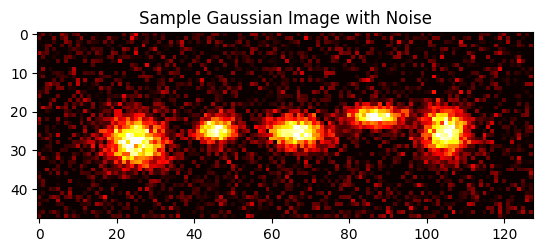

Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):
[[ 2.2604115e+01  3.0724833e+01  5.9024916e+00  2.3851886e+00
   1.0953716e-01]
 [ 4.2987415e+01  2.2762440e+01  3.1326425e+00  1.1353354e+00
  -1.5863462e-01]
 [ 6.5766541e+01  2.2519472e+01  3.4035640e+00  4.5759134e+00
   9.3446031e-02]
 [ 8.6373444e+01  2.8244846e+01  2.0362117e+00  2.1468098e+00
   1.2065669e-02]
 [ 1.1086132e+02  2.9109991e+01  3.4134243e+00  3.9914999e+00
  -1.7319742e-01]]


In [7]:
# Generate the training data
num_samples = 10000
X, y = create_training_data(num_samples)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], 48, 128, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 128, 1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Visualize a sample image and its Gaussians
plt.imshow(X_train[0].squeeze(), cmap='hot')
plt.title("Sample Gaussian Image with Noise")
plt.show()

print("Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):")
print(y_val[0])

In [ ]:
model = build_cnn_with_gaussian_prediction()

model.compile(optimizer='adam', loss = mse)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
)